FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

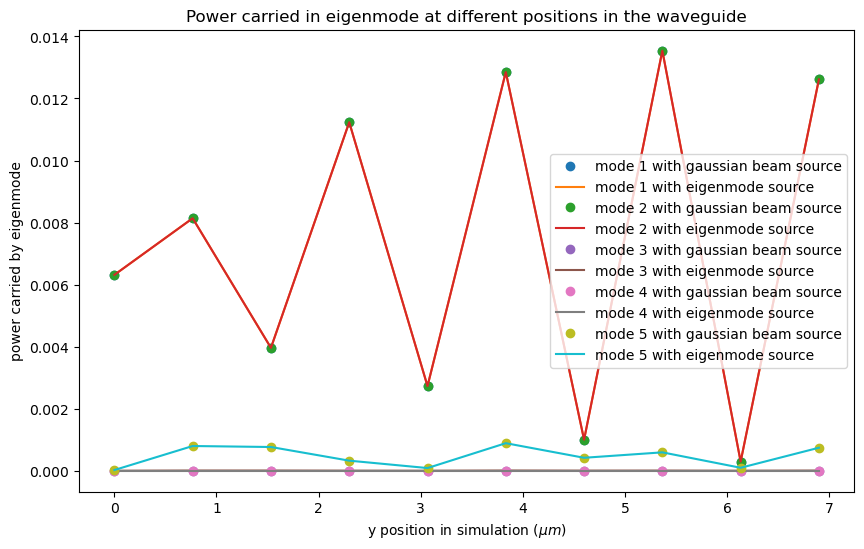

In [2]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
mp.verbosity(0)

resolution = 30 # pixels per micrometer
Sx = 8
Sy = 10
cell_size = mp.Vector3(Sx,Sy)
pml_width = 1
pml_layers = [mp.PML(thickness=pml_width)]

lambda1 = 1.55
lambda2 = lambda1/2
band_numbers = [i for i in range(1,6)]    # band number (mode index) of eigenmode.

fcen1 = lambda1
df = 0
nfreq = 1

w = 1.0 # width of waveguide
geometry = [mp.Block(center=mp.Vector3(),
                     size=mp.Vector3(w,mp.inf),
                     material=mp.Medium(index=2.1))]

kpoint = mp.Vector3(y=1) # Tells which direction to find the mode in

gaussian_sources = [mp.GaussianBeamSource(mp.ContinuousSource(wavelength=lambda1),
                                          component=mp.Ey,
                                          center=mp.Vector3(0, -Sy/2+2*pml_width),
                                          size=mp.Vector3(w,0),
                                          beam_kdir=kpoint,
                                          beam_w0=w,
                                          beam_E0=mp.Vector3(x=1))]

eigenmode_sources = [mp.EigenModeSource(mp.ContinuousSource(wavelength=lambda1),
                                        center=mp.Vector3(0, -Sy/2+2*pml_width),
                                        size=mp.Vector3(w,0),
                                        direction=mp.Y,
                                        eig_kpoint=kpoint,
                                        eig_band=3,
                                        eig_match_freq=True)]

gauss_sim = mp.Simulation(cell_size=cell_size,
                          resolution=resolution,
                          boundary_layers=pml_layers,
                          sources=gaussian_sources,
                          geometry=geometry)

eig_sim = mp.Simulation(cell_size=cell_size,
                        resolution=resolution,
                        boundary_layers=pml_layers,
                        sources=eigenmode_sources,
                        geometry=geometry)

monitor_positions = np.linspace(-Sy/2 + 2*pml_width+0.1, Sy/2 - pml_width, 10)
monitor_vectors = [mp.Vector3(y=mon_pos) for mon_pos in monitor_positions]
mode_regions = [mp.FluxRegion(center=mon_vec, size=mp.Vector3(x=w))
                for mon_vec in monitor_vectors]  # Center Coordinate of the Eigenmonitor
eig_monitors_gauss_sim = []
eig_monitors_eigen_sim = []
for mode_reg in mode_regions:
    eig_monitors_gauss_sim.append(gauss_sim.add_mode_monitor(fcen1, df, nfreq, mode_reg))
    eig_monitors_eigen_sim.append(eig_sim.add_mode_monitor(fcen1, df, nfreq, mode_reg))

# gauss_sim.run(mp.to_appended("out/ex-gauss", mp.at_every(0.5, mp.output_efield_x)), until=100)
# eig_sim.run(mp.to_appended("out/ex-eigen", mp.at_every(0.5, mp.output_efield_x)), until=100)

gauss_sim.run(until=100)
eig_sim.run(until=100)

gauss_source_mode_results = [gauss_sim.get_eigenmode_coefficients(monitor, band_numbers) for monitor in eig_monitors_gauss_sim]
eigen_source_mode_results = [eig_sim.get_eigenmode_coefficients(monitor, band_numbers) for monitor in eig_monitors_eigen_sim]
gauss_alpha = np.array([result.alpha[:,0,0] for result in gauss_source_mode_results])
eigen_alpha = np.array([result.alpha[:,0,0] for result in gauss_source_mode_results])
gauss_power = np.abs(gauss_alpha)**2
eigen_power = np.abs(eigen_alpha)**2

plt.figure(figsize=(10,6))
for i in range(gauss_power.shape[-1]):
    plt.plot(monitor_positions - monitor_positions[0], gauss_power[:,i], 'o', label=f'mode {i+1} with gaussian beam source')
    plt.plot(monitor_positions - monitor_positions[0], eigen_power[:,i], label=f'mode {i+1} with eigenmode source')
plt.legend(loc='right')
plt.xlabel(r'y position in simulation ($\mu m$)')
plt.ylabel('power carried by eigenmode')
plt.yscale('linear')
plt.title('Power carried in eigenmode at different positions in the waveguide')
plt.show()